# Introduction

This Jupyter Notebook contains code for data analysis and processing

In [3]:
import re
import pandas as pd
from math import log10
import matplotlib.pyplot as plt
import os

In [42]:
def extractValueFromLine(lines, line, num, value_type):
    value = lines[lines.index(line)+num]
    if value_type == "int":
        return int(re.findall(r'\d+', value)[0])
    elif value_type == "float":
        # example: value = "thres = 1e-05" -> output 1e-05
        # 1. divide by = and remove ' '
        value = value.split('=')[1].strip()
        # 2. convert to float
        return float(value)
    elif value_type == "memory" or value_type == "memory_pick":
        memory, pick = getMemoryVals(value)
        if value_type == "memory":
            return memory
        else:
            return pick
    else:
        return None

def getResultSingleJob(job):
    output_all = getOutputFilenames(job)
    df1 = getResultStep1(output_all["step1"])
    df2 = getResultStep2(output_all["step2"])
    df3 = getResultStep3(output_all["step3"])
    df4 = getResultStep4(output_all["step4"])
    df5 = getResultStep5(output_all["step5"])
    df_total = pd.concat([df1, df2, df3, meanOfStep4(df4), df5], axis=1, join='outer')
    n_genes = df4['n_gene'].sum()
    n_batch = len(df4['4_num_batch'])
    df_param2 = pd.DataFrame({'job': [job], 'n_genes': [n_genes], 'num_batch': [n_batch]}, index=[0])
    df_total = pd.concat([df_total, df_param2], axis=1)
    return df_total

def getTotalResults(jobs_list):
    df_total = pd.DataFrame()
    for job in jobs_list:
        print("reading ", job)
        df = getResultSingleJob(job)
        df_total = pd.concat([df_total, df], axis=0)
    return df_total

def getOutputFilenames(job):
    OUTPUT_DIR = os.path.join(job, "slurm_out")
    OUTPUT_DIR_STEP4 = os.path.join(OUTPUT_DIR, "step4")
    OUTPUT_FILES_BATCH = os.listdir(OUTPUT_DIR_STEP4)
    output_file1 = os.path.join(OUTPUT_DIR, "step1.txt")
    output_file2 = os.path.join(OUTPUT_DIR, "step2.txt")
    output_file3 = os.path.join(OUTPUT_DIR, "step3.txt")
    output_file5 = os.path.join(OUTPUT_DIR, "step5.txt")
    output_file4 = [os.path.join(OUTPUT_DIR_STEP4, f) for f in OUTPUT_FILES_BATCH]
    output_all = {
        "step1": output_file1,
        "step2": output_file2,
        "step3": output_file3,
        "step4": output_file4,
        "step5": output_file5
    }
    return output_all

def getFileSizeFromLine(line):
    equal_sign_index = line.index('=')
    val_str = line[equal_sign_index + 1:].strip()
    if 'KB' in line:
        kb_index = val_str.index('KB')
        val = val_str[:kb_index].strip()
    else:
        gb_index = val_str.index('GB')
        val = val_str[:gb_index].strip()
    return val
    
def getMemoryVals(line):
    # Find the index of '(' and ')' to isolate the memory and pick memory information
    open_bracket_index = line.find('(')
    close_bracket_index = line.find(')')

    # Extract memory usage and pick memory substrings
    memory_info_pick = line[open_bracket_index + 1:close_bracket_index]

    # Split the memory info into memory and pick memory parts
    memory_info_final = line[:open_bracket_index]
    # Extract memory usage and pick memory values and remove leading and trailing spaces
    memory_usage = float(re.findall(r'\d+', memory_info_final)[0])
    pick_memory = float(re.findall(r'\d+', memory_info_pick)[0])
    
    # check if the memory is in GB or MB
    if 'MB' in memory_info_final:
        memory_usage = memory_usage / 1024.
    if 'MB' in memory_info_pick:
        pick_memory = pick_memory / 1024.
    return memory_usage, pick_memory


def getResultStep1(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    df = pd.DataFrame()
    row = {}
    for line in lines:
        if "default parameters" in line:
            row["k"] = extractValueFromLine(lines, line, 1, "int")
            row["thres"] = extractValueFromLine(lines, line, 2, "float")
            row["target"] = extractValueFromLine(lines, line, 3, "int")
        
        if " === Duration summaries ===" in line:
            row['1_readFastaFile'] = extractValueFromLine(lines, line, 1, "int")
            row['1_computeKmerTable'] = extractValueFromLine(lines, line, 2, "int")
            row['1_save'] = extractValueFromLine(lines, line, 3, "int")
            row['1_Memory usage'] = extractValueFromLine(lines, line, 7, "memory")
            row['1_pick Memory usage'] = extractValueFromLine(lines, line, 7, "memory_pick")
    df = df.append(row, ignore_index=True)
    return df

def getResultStep2(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    df = pd.DataFrame()
    row = {}
    for line in lines:
        if " === Duration summaries ===" in line:
            line_context = lines[lines.index(line) + 1]
            context = getFileSizeFromLine(lines[lines.index(line) + 5])
            public = getFileSizeFromLine(lines[lines.index(line) + 6])
            private = getFileSizeFromLine(lines[lines.index(line) + 7])
            mult = getFileSizeFromLine(lines[lines.index(line) + 8])
            row['2_GenCryptoContext'] = extractValueFromLine(lines, line, 1, "int")
            row['2_KeyGen'] = extractValueFromLine(lines, line, 2, "int")
            row['2_Serialize'] = extractValueFromLine(lines, line, 3, "int")
            row['2_context'] = context
            row['2_public'] = public
            row['2_private'] = private
            row['2_eval-mult'] = mult
            row['2_Memory usage'] = extractValueFromLine(lines, line, 9, "memory")
            row['2_Pick Memory usage'] = extractValueFromLine(lines, line, 9, "memory_pick")    
    df = df.append(row, ignore_index=True)
    return df



def getResultStep3(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    df = pd.DataFrame()
    row = {}
    for line in lines:
        if "n_kmer_total = " in line:
            row['n_kmer_total'] = extractValueFromLine(lines, line, 0, "int")
        if " === Duration summaries ===" in line:
            row['3_readFastaFile'] = extractValueFromLine(lines, line, 1, "int")
            row['3_load_kmerList'] = extractValueFromLine(lines, line, 2, "int")
            row['3_encodeRead'] = extractValueFromLine(lines, line, 3, "int")
            row['3_EncryptReadKmer'] = extractValueFromLine(lines, line, 4, "int")
            row['3_serializeCtxtRead'] = extractValueFromLine(lines, line, 5, "int")
            row['3_Memory usage'] = extractValueFromLine(lines, line, 11, "memory")
            row['3_Pick Memory usage'] = extractValueFromLine(lines, line, 11, "memory_pick")
    df = df.append(row, ignore_index=True)
    return df

def getResultStep4(files):
    df_total = pd.DataFrame()
    for filename in files:
        num_batch = int(re.findall(r'\d+', filename)[-1])
        with open(filename, 'r') as file:
            lines = file.readlines()
        row = {}

        for line in lines:
            if " == conditional parameters ==" in line:
                gene_start = extractValueFromLine(lines, line, 2, "int")
                gene_end = extractValueFromLine(lines, line, 3, "int")
                n_gene = gene_end - gene_start + 1
                row['n_gene'] = n_gene
                n_gene = float(n_gene)
            if " === Duration summaries ===" in line:
                row['4_loadKmerTable'] = extractValueFromLine(lines, line, 1, "int")
                row['4_loadKmerList'] = extractValueFromLine(lines, line, 2, "int")
                row['4_readCtxtRead'] = extractValueFromLine(lines, line, 3, "int")
                row['4_encodeAndMult_per_gene'] = extractValueFromLine(lines, line, 4, "int") / n_gene
                row['4_serializeCtxtOut_per_gene'] = extractValueFromLine(lines, line, 5, "int") / n_gene
                row['4_Memory usage'] = extractValueFromLine(lines, line, 10, "memory")
                row['4_Memory_per_gene'] = extractValueFromLine(lines, line, 10, "memory") / n_gene
                row['4_Pick Memory usage'] = extractValueFromLine(lines, line, 10, "memory_pick")
                row['4_num_batch'] = num_batch
        df_total = df_total.append(row, ignore_index=True)
    return df_total

def meanOfStep4(df4):
    # remove batch column
    df4 = df4.drop(columns=["4_num_batch"])
    # compute mean of each column and save as a one-row dataframe
    df4_mean = df4.mean()
    df4_mean = df4_mean.to_frame().transpose()
    return df4_mean

def getResultStep5(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    df = pd.DataFrame()
    row = {}
    for line in lines:
        if " === Duration summaries ===" in line:
            row['5_loadKmerTable'] = extractValueFromLine(lines, line, 1, "int")
            row['5_readCtxtOut'] = extractValueFromLine(lines, line, 2, "int")
            row['5_decryptOutput'] = extractValueFromLine(lines, line, 3, "int")
            row['5_Memory usage'] = extractValueFromLine(lines, line, 5, "memory")
            row['5_Pick Memory usage'] = extractValueFromLine(lines, line, 5, "memory_pick")
    df = df.append(row, ignore_index=True)
    return df

In [43]:
BASE_FOLDER = "../out/030724"
JOBS_LIST = [BASE_FOLDER + "/" + job for job in os.listdir(BASE_FOLDER)]

print(JOBS_LIST)
print("# of jobs: ", len(JOBS_LIST))
df_total = getTotalResults(JOBS_LIST)

['../out/030724/42751428', '../out/030724/42751418', '../out/030724/42751408', '../out/030724/42751424', '../out/030724/42751421', '../out/030724/42751411', '../out/030724/42751426', '../out/030724/42751416', '../out/030724/42751422', '../out/030724/42751412', '../out/030724/42751427', '../out/030724/42751417', '../out/030724/42751414', '../out/030724/42751430', '../out/030724/42751420', '../out/030724/42751410', '../out/030724/42751429', '../out/030724/42751419', '../out/030724/42751409', '../out/030724/42751425', '../out/030724/42751415', '../out/030724/42751431', '../out/030724/42751407', '../out/030724/42751423', '../out/030724/42751413']
# of jobs:  25
reading  ../out/030724/42751428
reading  ../out/030724/42751418
reading  ../out/030724/42751408
reading  ../out/030724/42751424
reading  ../out/030724/42751421


In [38]:
#sort df_total by k
df_total = df_total.sort_values(by=['k'])
df_total.columns

Index(['k', 'thres', 'target', '1_readFastaFile', '1_computeKmerTable',
       '1_save', '1_Memory usage', '1_pick Memory usage', '2_GenCryptoContext',
       '2_KeyGen', '2_Serialize', '2_context', '2_public', '2_private',
       '2_eval-mult', '2_Memory usage', '2_Pick Memory usage', 'n_kmer_total',
       '3_readFastaFile', '3_load_kmerList', '3_encodeRead',
       '3_EncryptReadKmer', '3_serializeCtxtRead', '3_Memory usage',
       '3_Pick Memory usage', 'n_gene', '4_loadKmerTable', '4_loadKmerList',
       '4_readCtxtRead', '4_encodeAndMult', '4_serializeCtxtOut',
       '4_Memory usage', '4_Memory_per_gene', '4_Pick Memory usage',
       '5_loadKmerTable', '5_readCtxtOut', '5_decryptOutput', '5_Memory usage',
       '5_Pick Memory usage', 'job', 'n_genes', 'num_batch'],
      dtype='object')

In [39]:
df_total.to_csv(BASE_FOLDER +"/../summary_030724.tsv")

In [41]:
PARAMS = ['k', 'thres', 'target', 'n_genes', 'num_batch', 'n_kmer_total']
SERVER_PREPROCESS = ["1_computeKmerTable"]
SERVER_COMPUTATION = ["4_encodeAndMult_per_gene"]
SERVER_SAVE_LOAD = ["1_readFastaFile", "1_save", "4_loadKmerTable", "4_loadKmerList", "4_serializeCtxtOut_per_gene"]
SERVER_MEMORY = ["1_Memory usage", "4_Memory usage_per_gene"]
SERVER_PICK_MEMORY = ["1_pick Memory usage", "4_Pick Memory usage"]

USER_HE_GEN = ["2_GenCryptoContext", "2_KeyGen"]
USER_ENCRYPT = ["3_encodeRead", "3_EncryptReadKmer"]
USER_DECRYPT = ["5_decryptOutput"]
USER_SAVE_LOAD = ["2_Serialize", "3_load_kmerList", "3_readFastaFile", "3_serializeCtxtRead", "5_loadKmerTable", "5_readCtxtOut"]
USER_MEMORY = ["2_Memory usage", "2_Pick Memory usage", "3_Memory usage", "3_Pick Memory usage", "5_Memory usage", "5_Pick Memory usage"]

df_total = pd.read_csv(BASE_FOLDER + "/../summary_030724.tsv")
# df_total.head()
print(df_total.loc[:, ['k', 'thres'] + SERVER_COMPUTATION])

       k         thres  4_encodeAndMult
0   15.0  1.000000e-07       374419.924
1   15.0  1.000000e-05       402609.024
2   15.0  1.000000e-03       368534.544
3   15.0  1.000000e+02       402960.996
4   15.0  1.000000e-01       369167.256
5   20.0  1.000000e-03       502492.080
6   20.0  1.000000e-01       506176.532
7   20.0  1.000000e-07       507557.528
8   20.0  1.000000e-05       504121.260
9   20.0  1.000000e+02       501497.492
10  25.0  1.000000e-07       556315.572
11  25.0  1.000000e-01       552207.124
12  25.0  1.000000e-03       566966.132
13  25.0  1.000000e+02       554715.180
14  25.0  1.000000e-05       558810.088
15  30.0  1.000000e-05       609509.552
16  30.0  1.000000e+02       617711.636
17  30.0  1.000000e-01       617623.056
18  30.0  1.000000e-03       623198.836
19  30.0  1.000000e-07       614851.012
20  35.0  1.000000e-07       638610.584
21  35.0  1.000000e-01       641527.404
22  35.0  1.000000e-03       635402.868
23  35.0  1.000000e+02       661444.548


In [17]:
# def plotEachColumn(df, col, title):
#     plt.figure()
#     for thres in df['thres'].unique():
#         df_thres = df[df['thres'] == thres]
#         plt.plot(df_thres['k'], df_thres[col], label=thres)
#     plt.title(col)
#     plt.xlabel('k')
#     plt.ylabel(param)
#     plt.xlim(10, 30)
#     plt.legend()
#     plt.savefig(os.path.join(PLOT_DIR, title + ".png"))
#     plt.show()
    
PLOT_DIR = "plot_fancy"
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats
from sklearn.metrics import r2_score, mean_squared_error

def plotEachColumnFancy(df, col, title):
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    
    # Create line plot with 'thres' as hue
    sns.lineplot(
        data=df,
        x='k',
        y=col,  # Use the specified column as y
        hue='thres',  # Specify 'thres' column as hue
        palette='colorblind',  # Choose a palette for better visibility of different lines
        linewidth=2,  # Adjust line width if needed
        markers=True,  # Add markers to the lines
        style='thres',  # Use 'thres' values to distinguish different line styles
        markersize=8,  # Adjust marker size if needed
        markeredgecolor='black',  # Set marker edge color
        markeredgewidth=1.5  # Set marker edge width
    )

    plt.title(title)  # Set the title of the plot
    plt.xlabel('k')  # Set the label for the x-axis
    plt.ylabel(col)  # Set the label for the y-axis
    plt.legend(title='Threshold')  # Add legend with title
    
    # Set x-axis ticks to integer values corresponding to 'k'
    plt.xticks(df['k'].unique(), map(int, df['k'].unique()))
    
    plt.grid(True)  # Add grid for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()


In [18]:
from scipy import stats
from sklearn.metrics import r2_score, mean_squared_error


fs=9

style_constants = {
    "fs": fs,
    "grid_grey": "#c6c6c6",
    "solid_grid_grey": "#E0E0E0",
    "linewidth": 6.202,
    "grey": "#BDBDBD",
    "border_width": 0.5,
    "sns_rc": {
        "font.size": fs,
        "axes.titlesize": fs + 2,
        "axes.labelsize": fs,
        "xtick.labelsize": fs,
        "ytick.labelsize": fs,
        "legend.fontsize": fs,
        "legend.title_fontsize": fs,
        "legend.frameon": False,
        "axes.linewidth": 0.5,
        "lines.linewidth": 1.75,
    },
    "tick_len": 3.5,
}

def style_fonts():
    fpath = "/gpfs/commons/groups/gursoy_lab/cwalker/tools/miniconda3/envs/jup/fonts/arial.ttf"
    mpl.font_manager.FontProperties(fname=fpath)
    mpl.rcParams["font.sans-serif"] = "Arial"
    mpl.rcParams["font.family"] = "sans-serif"
    mpl.rcParams["mathtext.default"] = "regular"
    mpl.rcParams["figure.dpi"] = 100



def style_scatterplot(ax, gridlinestyle="solid", xy_line=False):
    sns.set_style("white", {"legend.frameon": False})
    style_fonts()
    style = style_constants
    sns.set_context("paper", rc=style["sns_rc"])

    if gridlinestyle == "solid":
        gridcol =  style["solid_grid_grey"]
    elif gridlinestyle == "dotted":
        gridcol = style["grid_grey"]

    sns.despine(left=True, bottom=True)

    ax.tick_params("y", which="major", pad=-2)
    ax.tick_params("x", which="major", pad=-2)
    ax.set_axisbelow(True)
    ax.yaxis.grid(color=gridcol, linestyle=gridlinestyle)
    ax.xaxis.grid(color=gridcol, linestyle=gridlinestyle)
    ax.tick_params(axis="y", which="both", left=False)

    if xy_line:
        ax.axline(
            [0, 0],
            [1, 1],
            zorder=0,
            color="grey",
            linestyle="dashed", 
            linewidth=0.5,
        )

    return ax


In [29]:
df_plot = df_total.loc[:, ['k', 'thres', 'n_kmer_total']]
# set column k as integer type
df_plot['k'] = df_plot['k'].astype(int)
# sort by thres first
df_plot = df_plot.sort_values(by=['thres'])
# let thres falue to 1ex format
df_plot['thres'] = df_plot['thres'].apply(lambda x: "{:.0e}".format(float(x)).replace("e+0", "e+").replace("e-0", "e-"))
# n_kmer_total -> log
df_plot['n_kmer_total'] = df_plot['n_kmer_total'].apply(lambda x: log10(x))


n_genes = df_total['n_genes'].unique()

print("n_genes = ", n_genes)
unit_sec = 1000
unit_min = 1000 * 60 # minute

# average per gene
df_plot['server_preprocess'] = df_total[SERVER_PREPROCESS].sum(axis=1) / unit_sec / n_genes
df_plot['server_computation'] = df_total[SERVER_COPMUTATION].sum(axis=1) / unit_sec
df_plot['user_encode_and_encrypt'] = df_total[USER_ENCRYPT].sum(axis=1) / unit_sec
df_plot['user_decrypt'] = df_total[USER_DECRYPT].sum(axis=1) / unit_sec
df_plot['server_total_memory'] = df_total[SERVER_MEMORY].sum(axis=1)

print(df_plot.head())
print(df_total[SERVER_COPMUTATION])

n_genes =  [5000.]
     k thres  n_kmer_total  server_preprocess  server_computation  \
0   15  1e-7      7.627973           0.086061           18.720996   
20  35  1e-7      7.841084           0.114017           31.930529   
19  30  1e-7      7.826693           0.105207           30.742551   
10  25  1e-7      7.786500           0.092171           27.815779   
7   20  1e-7      7.740766           0.107073           25.377876   

    user_encode_and_encrypt  user_decrypt  server_total_memory  
0                    46.178         5.151                 35.0  
20                   73.352         5.019                 56.0  
19                   70.625         5.015                 54.0  
10                   64.299         5.105                 49.0  
7                    59.480         4.914                 44.0  
    4_encodeAndMult
0        18720.9962
1        20130.4512
2        18426.7272
3        20148.0498
4        18458.3628
5        25124.6040
6        25308.8266
7        25377.8

In [6]:
plot_settings_data = [
    ("server_preprocess", "Time (sec / gene)", "Reference Indexing", (0, 15), "line"),
    ("server_computation", "Time (sec / gene)", "Server Computation", (0, 500), "line"),
    ("user_encode_and_encrypt", "Time (sec)", "User Encoding & Encryption", (0, 100), "line"),
    ("user_decrypt", "Time (sec)", "User Decryption", (0, 10), "line"),
    ("server_total_memory", "Size (GB)", "Server Memory", (100, 400), "bar"),
    ("n_kmer_total", "count (log10)", "Number of Kmers", (6, 10), "bar"),
]

# Create the DataFrame using the simplified syntax
plot_settings = pd.DataFrame(plot_settings_data, columns=['column', 'ylabel', 'title', 'ylim', 'plot_type'])

plot_settings

,column,ylabel,title,ylim,plot_type
0,server_preprocess,Time (min),Reference Indexing,"(0, 15)",line
1,server_computation,Time (min),Server Computation,"(0, 500)",line
2,user_encode_and_encrypt,Time (sec),User Encoding & Encryption,"(0, 100)",line
3,user_decrypt,Time (sec),User Decryption,"(0, 10)",line
4,server_total_memory,Size (GB),Server Memory,"(100, 400)",bar
5,n_kmer_total,count (log10),Number of Kmers,"(6, 10)",bar


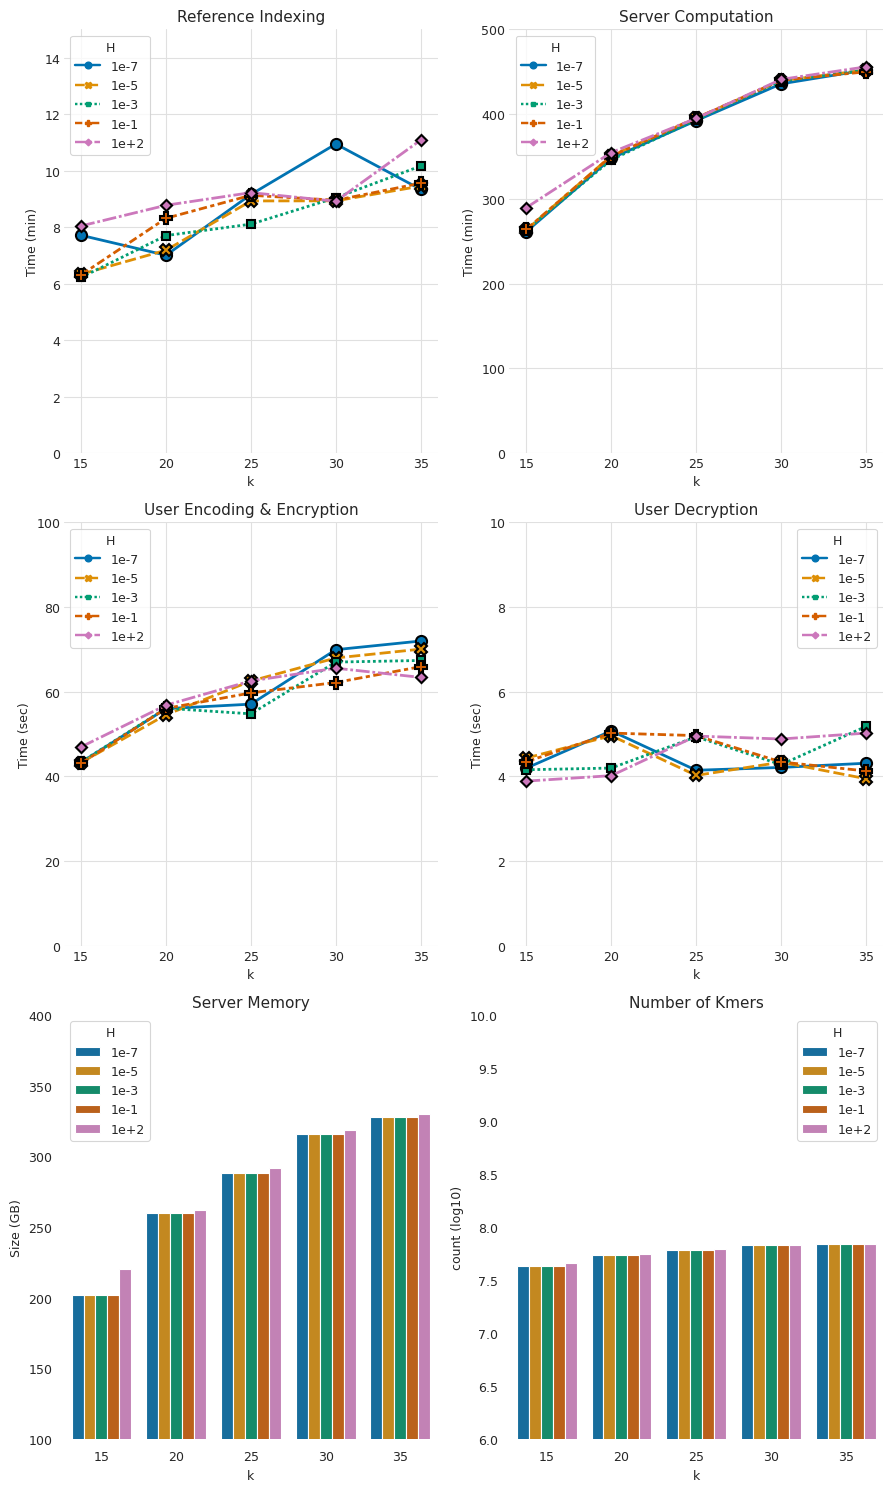

In [11]:
fig, ax = plt.subplots(3, 2, figsize=(9, 15))

for i in range(6):
    x, y = i // 2, i % 2
    # ax[i, 1].sharex(ax[i, 0])
    
    if plot_settings.at[i, 'plot_type'] == "line":
        sns.lineplot(
            data=df_plot,
            x='k',
            y=plot_settings.at[i, 'column'],  # Use the specified column as y
            hue='thres',  # Specify 'thres' column as hue
            palette='colorblind',  # Choose a palette for better visibility of different lines
            linewidth=2,  # Adjust line width if needed
            markers=True,  # Add markers to the lines
            style='thres',  # Use 'thres' values to distinguish different line styles
            markersize=8,  # Adjust marker size if needed
            markeredgecolor='black',  # Set marker edge color
            ax=ax[x][y],
            markeredgewidth=1.5,  # Set marker edge width
        )
        # ax[x][y].set_xlabel(f"k")
        # ax[x][y].set_title(plot_settings.at[i, 'title'])
        # ax[x][y].set_ylabel(plot_settings.at[i, 'ylabel'])
        # ax[x][y].set_ylim(plot_settings.at[i, 'ylim'])
        # ax[x][y].legend(title='H')
        # Set x-axis ticks to integer values corresponding to 'k'
        ax[x][y].set_xticks(df_plot['k'].unique())
        style_scatterplot(ax=ax[x][y])
    elif plot_settings.at[i, 'plot_type'] == "bar":
        sns.barplot(
            data=df_plot,
            x='k',
            y=plot_settings.at[i, 'column'],  # Use the specified column as y
            hue='thres',  # Specify 'thres' column as hue
            palette='colorblind',  # Choose a palette for better visibility of different bars
            ax=ax[x][y],
        )
    else:
        print("error")
        exit(0)
    ax[x][y].set_xlabel(f"k")
    ax[x][y].set_title(plot_settings.at[i, 'title'])
    ax[x][y].set_ylabel(plot_settings.at[i, 'ylabel'])
    ax[x][y].set_ylim(plot_settings.at[i, 'ylim'])
    ax[x][y].legend(title='H')

fig.tight_layout()
# save fig to plot/final.png
fig.savefig("plot_fancy/figure_SH.png")

      k         thres  target  n_genes  num_batch  n_kmer_total  \
0  15.0  1.000000e-07     1.0   5000.0        250    42459354.0   
1  15.0  1.000000e+02     1.0   5000.0        250    46130020.0   
2  15.0  1.000000e-05     1.0   5000.0        250    42459354.0   
3  15.0  1.000000e-03     1.0   5000.0        250    42459354.0   
4  15.0  1.000000e-01     1.0   5000.0        250    42459686.0   

   1_computeKmerTable  4_encodeReference  
0             448.381          14.117758  
1             466.716          15.695468  
2             365.537          14.252673  
3             358.635          14.255383  
4             364.100          14.332443  


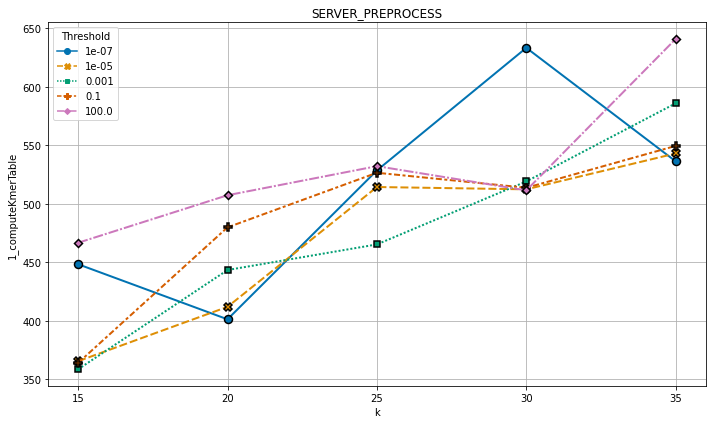

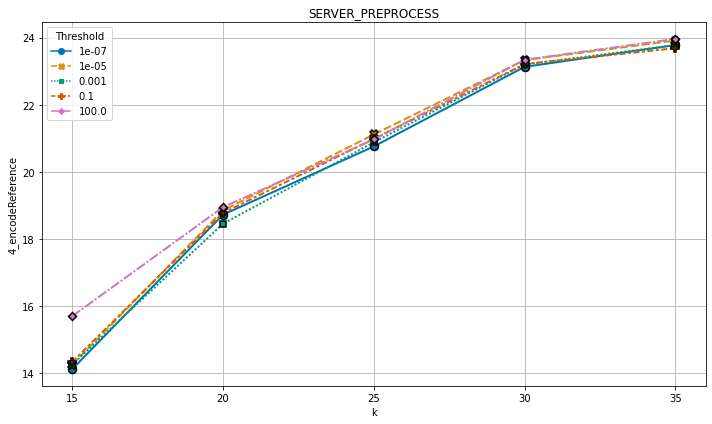

In [16]:
df = df_total.loc[:, PARAMS + SERVER_PREPROCESS]
df[SERVER_PREPROCESS] = df[SERVER_PREPROCESS] / 1000
print(df.head())

for param in SERVER_PREPROCESS:
    plotEachColumnFancy(df, param, "SERVER_PREPROCESS")

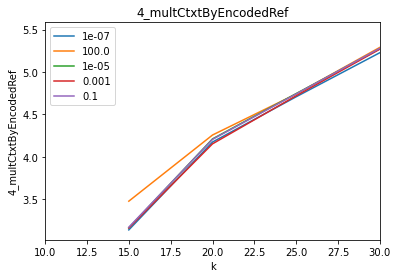

In [12]:
df = df_total.loc[:, PARAMS + SERVER_COPMUTATION]
df[SERVER_COPMUTATION] = df[SERVER_COPMUTATION] / 1000
df
for param in SERVER_COPMUTATION:
    plotEachColumn(df, param, "SERVER_COPMUTATION")

      k         thres  target  n_genes  num_batch  n_kmer_total  \
0  15.0  1.000000e-07     1.0   5000.0        250    42459354.0   
0  15.0  1.000000e+02     1.0   5000.0        250    46130020.0   
0  15.0  1.000000e-05     1.0   5000.0        250    42459354.0   
0  15.0  1.000000e-03     1.0   5000.0        250    42459354.0   
0  15.0  1.000000e-01     1.0   5000.0        250    42459686.0   
0  20.0  1.000000e-03     1.0   5000.0        250    55051111.0   
0  20.0  1.000000e-07     1.0   5000.0        250    55051111.0   
0  20.0  1.000000e+02     1.0   5000.0        250    55772010.0   
0  20.0  1.000000e-05     1.0   5000.0        250    55051111.0   
0  20.0  1.000000e-01     1.0   5000.0        250    55051117.0   
0  25.0  1.000000e-07     1.0   5000.0        250    61164526.0   
0  25.0  1.000000e-01     1.0   5000.0        250    61164530.0   
0  25.0  1.000000e-05     1.0   5000.0        250    61164526.0   
0  25.0  1.000000e+02     1.0   5000.0        250    61817026.

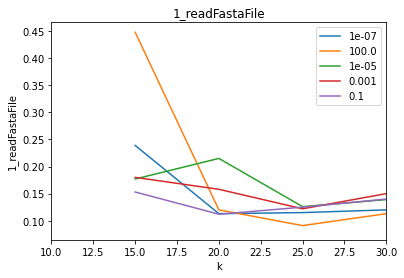

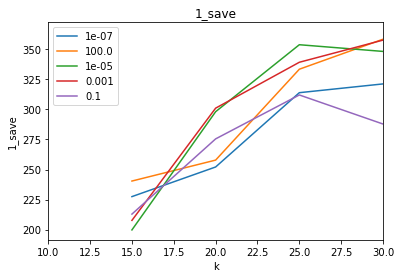

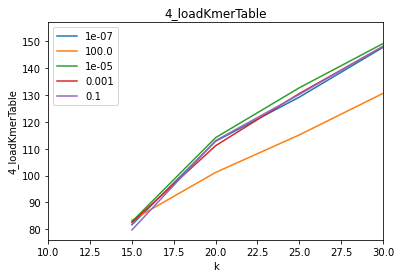

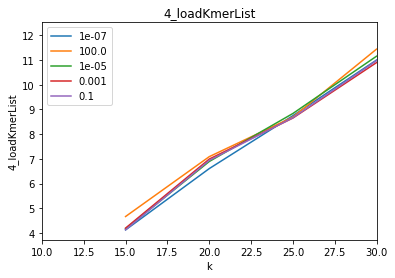

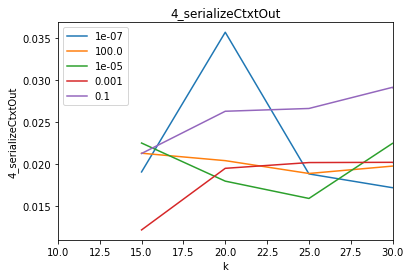

In [13]:
df = df_total.loc[:, PARAMS + SERVER_SAVE_LOAD]
df[SERVER_SAVE_LOAD] = df[SERVER_SAVE_LOAD] / 1000
df["total"] = df[SERVER_SAVE_LOAD].sum(axis=1)
print(df)
for param in SERVER_SAVE_LOAD:
    plotEachColumn(df, param, "SERVER_SAVE_LOAD")

      k         thres  target  n_genes  num_batch  n_kmer_total  \
0  15.0  1.000000e-07     1.0   5000.0        250    42459354.0   
0  15.0  1.000000e+02     1.0   5000.0        250    46130020.0   
0  15.0  1.000000e-05     1.0   5000.0        250    42459354.0   
0  15.0  1.000000e-03     1.0   5000.0        250    42459354.0   
0  15.0  1.000000e-01     1.0   5000.0        250    42459686.0   
0  20.0  1.000000e-03     1.0   5000.0        250    55051111.0   
0  20.0  1.000000e-07     1.0   5000.0        250    55051111.0   
0  20.0  1.000000e+02     1.0   5000.0        250    55772010.0   
0  20.0  1.000000e-05     1.0   5000.0        250    55051111.0   
0  20.0  1.000000e-01     1.0   5000.0        250    55051117.0   
0  25.0  1.000000e-07     1.0   5000.0        250    61164526.0   
0  25.0  1.000000e-01     1.0   5000.0        250    61164530.0   
0  25.0  1.000000e-05     1.0   5000.0        250    61164526.0   
0  25.0  1.000000e+02     1.0   5000.0        250    61817026.

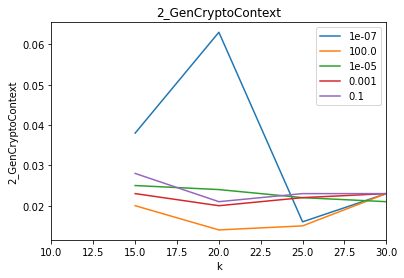

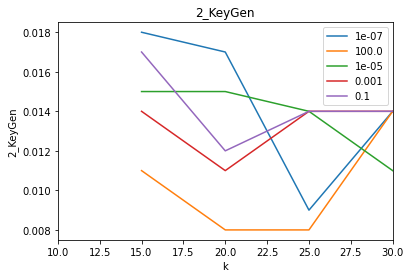

In [14]:
df = df_total.loc[:, PARAMS + USER_HE_GEN]
df[USER_HE_GEN] = df[USER_HE_GEN] / 1000
print(df)
for param in USER_HE_GEN:
    plotEachColumn(df, param, "USER_HE_GEN")

      k         thres  target  n_genes  num_batch  n_kmer_total  3_encodeRead  \
0  15.0  1.000000e-07     1.0   5000.0        250    42459354.0         2.244   
0  15.0  1.000000e+02     1.0   5000.0        250    46130020.0         2.374   
0  15.0  1.000000e-05     1.0   5000.0        250    42459354.0         2.226   
0  15.0  1.000000e-03     1.0   5000.0        250    42459354.0         2.237   
0  15.0  1.000000e-01     1.0   5000.0        250    42459686.0         2.228   
0  20.0  1.000000e-03     1.0   5000.0        250    55051111.0         2.281   
0  20.0  1.000000e-07     1.0   5000.0        250    55051111.0         2.472   
0  20.0  1.000000e+02     1.0   5000.0        250    55772010.0         2.326   
0  20.0  1.000000e-05     1.0   5000.0        250    55051111.0         2.272   
0  20.0  1.000000e-01     1.0   5000.0        250    55051117.0         2.367   
0  25.0  1.000000e-07     1.0   5000.0        250    61164526.0         1.932   
0  25.0  1.000000e-01     1.

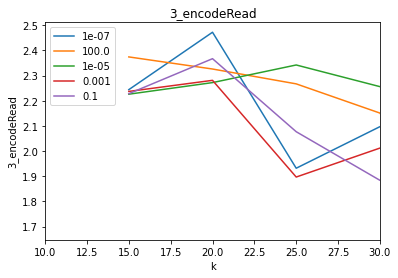

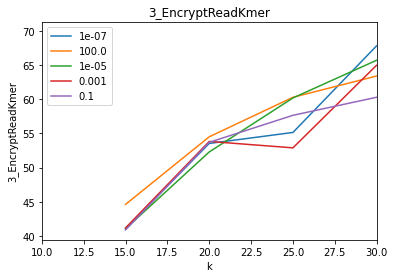

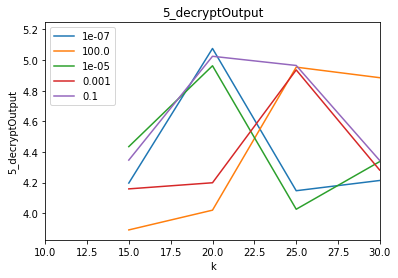

In [15]:
df = df_total.loc[:, PARAMS + USER_ENCRYPT + USER_DECRYPT]
df[USER_ENCRYPT + USER_DECRYPT] = df[USER_ENCRYPT + USER_DECRYPT] / 1000
print(df)
for param in USER_ENCRYPT + USER_DECRYPT:
    plotEachColumn(df, param, "USER_ENCRYPT + USER_DECRYPT")

      k         thres  target  n_genes  num_batch  n_kmer_total  2_Serialize  \
0  15.0  1.000000e-07     1.0   5000.0        250    42459354.0        0.105   
0  15.0  1.000000e+02     1.0   5000.0        250    46130020.0        0.017   
0  15.0  1.000000e-05     1.0   5000.0        250    42459354.0        0.022   
0  15.0  1.000000e-03     1.0   5000.0        250    42459354.0        0.023   
0  15.0  1.000000e-01     1.0   5000.0        250    42459686.0        0.026   
0  20.0  1.000000e-03     1.0   5000.0        250    55051111.0        0.014   
0  20.0  1.000000e-07     1.0   5000.0        250    55051111.0        0.021   
0  20.0  1.000000e+02     1.0   5000.0        250    55772010.0        0.017   
0  20.0  1.000000e-05     1.0   5000.0        250    55051111.0        0.018   
0  20.0  1.000000e-01     1.0   5000.0        250    55051117.0        0.013   
0  25.0  1.000000e-07     1.0   5000.0        250    61164526.0        0.036   
0  25.0  1.000000e-01     1.0   5000.0  

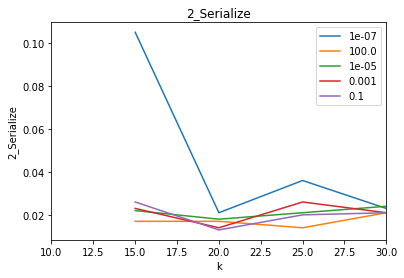

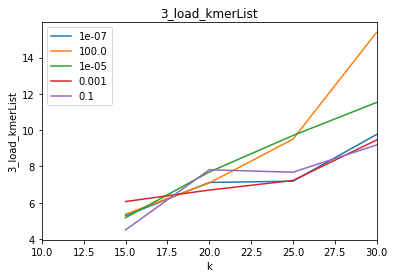

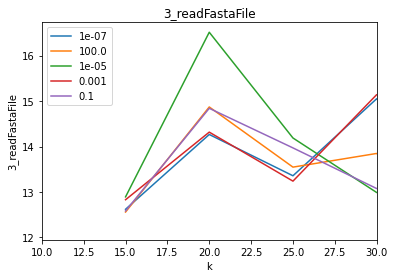

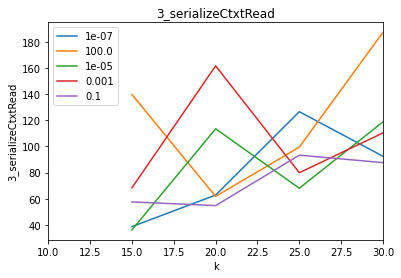

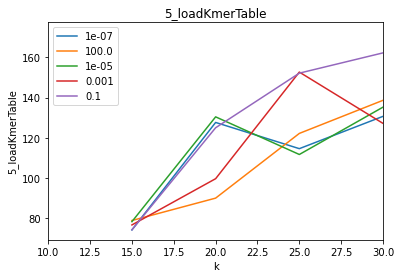

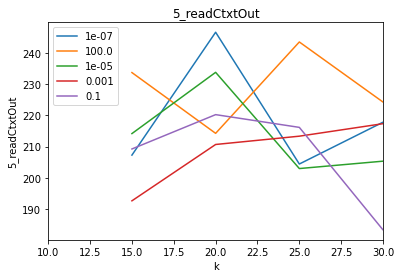

In [16]:
df = df_total.loc[:, PARAMS + USER_SAVE_LOAD]
df[USER_SAVE_LOAD] = df[USER_SAVE_LOAD] / 1000
df["total"] = df[USER_SAVE_LOAD].sum(axis=1)
print(df)
for param in USER_SAVE_LOAD:
    plotEachColumn(df, param, "USER_SAVE_LOAD")

      k         thres  target  n_genes  num_batch  n_kmer_total  \
0  15.0  1.000000e-07     1.0   5000.0        250    42459354.0   
0  15.0  1.000000e+02     1.0   5000.0        250    46130020.0   
0  15.0  1.000000e-05     1.0   5000.0        250    42459354.0   
0  15.0  1.000000e-03     1.0   5000.0        250    42459354.0   
0  15.0  1.000000e-01     1.0   5000.0        250    42459686.0   
0  20.0  1.000000e-03     1.0   5000.0        250    55051111.0   
0  20.0  1.000000e-07     1.0   5000.0        250    55051111.0   
0  20.0  1.000000e+02     1.0   5000.0        250    55772010.0   
0  20.0  1.000000e-05     1.0   5000.0        250    55051111.0   
0  20.0  1.000000e-01     1.0   5000.0        250    55051117.0   
0  25.0  1.000000e-07     1.0   5000.0        250    61164526.0   
0  25.0  1.000000e-01     1.0   5000.0        250    61164530.0   
0  25.0  1.000000e-05     1.0   5000.0        250    61164526.0   
0  25.0  1.000000e+02     1.0   5000.0        250    61817026.

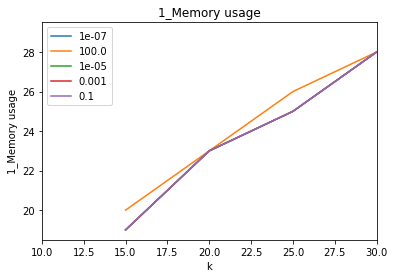

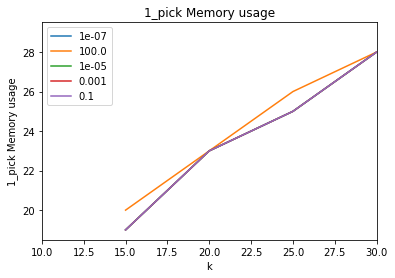

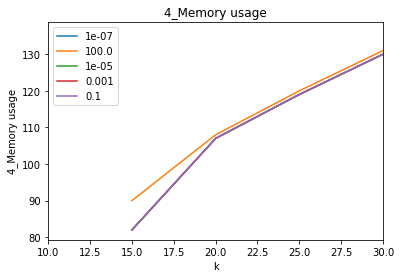

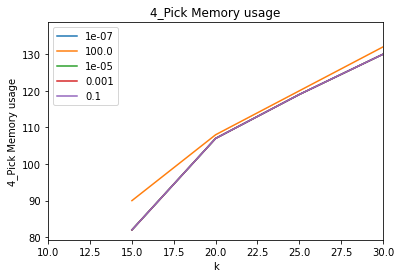

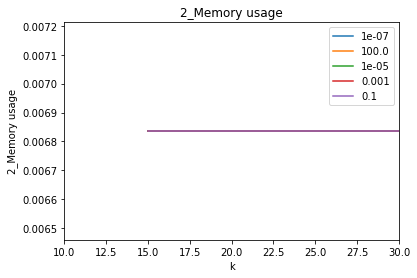

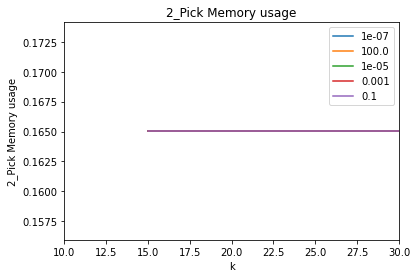

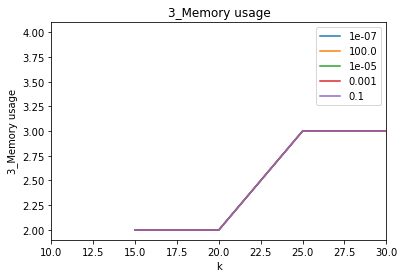

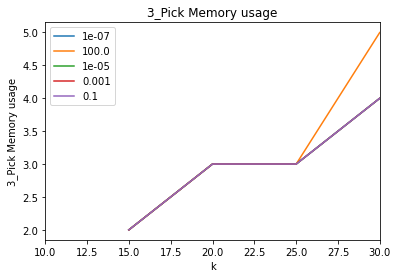

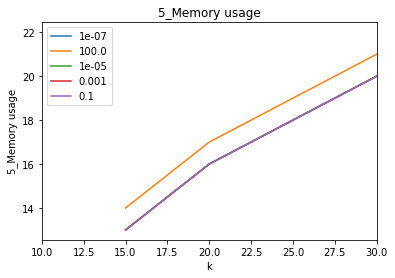

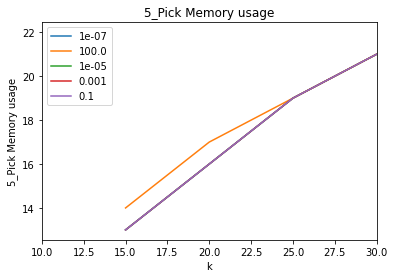

In [17]:
df = df_total.loc[:, PARAMS + SERVER_MEMORY + USER_MEMORY]
df["SERVER_MEM_TOTAL"] = df[SERVER_MEMORY].sum(axis=1)
df["USER_MEM_TOTAL"] = df[USER_MEMORY].sum(axis=1)
print(df)
for param in SERVER_MEMORY + USER_MEMORY:
    plotEachColumn(df, param, "SERVER_MEMORY + USER_MEMORY")

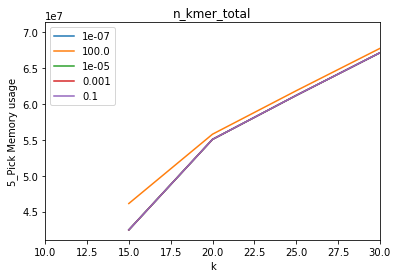

In [19]:
df = df_total.loc[:, PARAMS]
plotEachColumn(df, param, "SERVER_MEMORY + USER_MEMORY")